Ноутбук с генерации новостей по сгенерированному заголовку, а так же с постобработкой

* 0. Инициализация
* 1. Подготовка заголовков
* 2. Генерация статей
* 3. Примеры статей
* 4. Обработка сгенерированных статей
* 5. Увеличение длинны статьи 
* 6. Уход от паттернов генерации LLM

In [1]:
from utils_create_news import try_load, save_s3
from models.deepseekv3 import dsv3_api_request

from IPython.display import clear_output
from dotenv import load_dotenv
from openai import OpenAI
from minio import Minio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
import re

/Users/dan/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/6p/bshr1_dj3_7_gk1krflr4lzm0000gn/T/matplotlib-yon24190 because there was an issue with the default path (/Users/dan/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


# 0. Инициализация

In [2]:
load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
YANDEX_CLOUD_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID_2")
YANDEX_CLOUD_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY_2")
BUCKET_NAME = 'graduate'

PATH = '/Users/dan/git_repo/graduate/'

In [3]:
# DeepSeek client
client_dsv3 = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")

# Yandex s3 client
client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

# 1. Подготовка заголовков

In [66]:
# Придуманные названия статей от DeepSeek
gen_news_title_deepseek = try_load(file_path=PATH+'data/', file_name='gen_news_title_deepseek.pkl', client_s3=client_s3)

gen_news_title_deepseek[:5]

['Project 2025: How Trump’s Second Term Could Reshape America’s Future',
 'The AI Regulation Dilemma: Balancing Innovation and Civil Rights in 2025',
 'Medicaid Under Fire: The Looming Crisis in State Budgets',
 'Mass Deportations Begin: Inside Trump’s Immigration Crackdown',
 'The End of Title I? How Project 2025 Threatens Public Schools']

In [67]:
# Придуманные названия статей от 4o
gen_news_title_gpt4o = try_load(file_path=PATH+'data/', file_name='gen_news_title_gpt4o.pkl', client_s3=client_s3)

gen_news_title_gpt4o[:5]

["Europe's Shifting Center: Can Macron Hold the Line?",
 "Germany's Green Gamble: Energy Policy at a Crossroads",
 "Italy's Far-Right Resurgence: Meloni’s New Europe Vision",
 "Spain's Separatist Dilemma: Catalonia in 2025",
 'Sweden and NATO: A New Era in Neutrality']

In [70]:
# Биографии людей, которые упомянуты в зголовках статей
gen_news_title_names_bio = try_load(file_path=PATH+'data/', file_name='gen_news_title_names_bio.pkl', client_s3=client_s3)

gen_news_title_names_bio['Trump'], gen_news_title_names_bio['Biden']

("45th and 47th President of the United States, known for his 'America First' policies and significant influence on the Republican Party.",
 '46th President of the United States, serving since January 2021, focusing on unity and progressive reforms.')

Словарь в формате {название статьи : Биографич участников}

In [7]:
# Соединим статью с биографией участника статьи
ai_gen_news_title_and_bio = {}

for title in gen_news_title_deepseek + gen_news_title_gpt4o:
    bio_curr = ''
    for key in gen_news_title_names_bio:
        if key.lower() in title.lower():
            bio_curr += f'{key} bio: {gen_news_title_names_bio[key]}. '

    ai_gen_news_title_and_bio[title] = bio_curr

# 2. Генерация статей

In [50]:
deepseek_write_papers = try_load(file_path=PATH+'data/', file_name='deepseek_write_papers.pkl', client_s3=client_s3)

system_content_generate_news = (
        "You - AI-asistant - Author of news! "
        "Your task is to write an article! Come up with a situation on the topic of the proposed topic! "
        "If they give you a biography of a person, use that person's name in the article! "
        "Try to describe what is happening in detail, as if you were the author of the London Guardian newspaper! "
        "**The story should be logical and consistent! Write long paper 300-800 words!**"
        "**Do not write any information other than the article itself, do not write title!**"
        "**The content contains a title and possibly a biography**!"
    )

for i, (titile, bio) in enumerate(ai_gen_news_title_and_bio.items()):

    if titile not in deepseek_write_papers.keys():
    
        qwery = f'News headline: {titile}. BIO: {bio}'

        print(f'---START {i}---')
        print(f'Запрос: {qwery}, статья: ')

        ans = dsv3_api_request(client=client_dsv3, query=qwery, system_content=system_content_generate_news)
        ans = ans.choices[0].message.content
        ans = ans.replace('\n', '')

        clear_output(wait=True)

        print(f'Запрос: {qwery}, статья: \n{ans}')

        deepseek_write_papers[titile] = ans

        if i%25 == 0:
            save_s3(pickle_data=deepseek_write_papers, object_key='deepseek_write_papers.pkl', client_s3=client_s3)

            with open(PATH+'/data/deepseek_write_papers.pkl', 'wb') as file: 
                pickle.dump(deepseek_write_papers, file)

Запрос: News headline: U.S. State Secession Resolutions: Symbolism or Start?. BIO: , статья: 
In recent months, a quiet but growing movement has begun to ripple through several U.S. states, raising eyebrows and stirring debates about the future of the American union. Legislators in Texas, Florida, and even traditionally blue states like California have introduced resolutions—some symbolic, others more concrete—exploring the possibility of state secession. While the idea of states breaking away from the federal government is not new, the intensity and frequency of these discussions have reached levels not seen since the Civil War era.  The most vocal of these movements has been in Texas, where lawmakers have repeatedly floated the idea of a "Texit"—a play on Brexit—arguing that the state’s economic strength and cultural identity justify independence. Governor Greg Abbott has even gone so far as to suggest that Texas could "go it alone" if federal policies continue to clash with state pr

In [71]:
save_s3(pickle_data=deepseek_write_papers, object_key='deepseek_write_papers.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_write_papers.pkl', 'wb') as file: 
    pickle.dump(deepseek_write_papers, file)

print(f'Итого загружено {len(deepseek_write_papers)} статей')

Итого загружено 552 статей


# 3. Примеры статей

In [84]:
# Примеры статей с заголовками от deepseek-v3
for key in gen_news_title_deepseek[10:15]:
    paper = deepseek_write_papers[key]
    print(f'Title:   {key}, \nPaper:   {paper}\n')

Title:   Abortion in America: The Comstock Act’s Shocking Revival, 
Paper:   **Abortion in America: The Comstock Act’s Shocking Revival**  In a legal and political earthquake that has sent shockwaves across the United States, the long-dormant Comstock Act—a 19th-century anti-vice law—has resurfaced as a potent weapon in the battle over abortion rights. The 1873 statute, originally designed to ban the mailing of "obscene" materials, including contraceptives and abortion-related items, is now being wielded by conservative lawmakers and activists to further restrict access to reproductive healthcare in a post-Roe America.  The sudden revival of this antiquated law has stunned legal scholars and reproductive rights advocates, who warn that its broad language could criminalize the distribution of abortion pills, medical equipment, and even informational literature. The implications are staggering: if fully enforced, the Comstock Act could effectively ban abortion nationwide without the need

In [85]:
# Примеры статей с заголовками от 4o
for key in gen_news_title_gpt4o[10:15]:
    paper = deepseek_write_papers[key]
    print(f'Title:   {key}, \nPaper:   {paper}\n')

Title:   Germany’s Refugee Policy Reversal: What Changed?, 
Paper:   **Germany’s Refugee Policy Reversal: What Changed?**  For years, Germany stood as a beacon of openness in Europe, welcoming hundreds of thousands of refugees fleeing war and persecution. Chancellor Angela Merkel’s famous declaration in 2015—“Wir schaffen das” (“We can do this”)—became symbolic of the country’s commitment to humanitarian responsibility. But nearly a decade later, the political winds have shifted dramatically. The recent tightening of asylum laws and border controls marks a stark reversal from Germany’s once-lauded refugee policy. What led to this change, and what does it mean for the future of migration in Europe?  ### The Golden Era of Open Borders  In 2015, Germany opened its doors to over a million refugees, primarily from Syria, Iraq, and Afghanistan. The move was met with both praise and backlash—humanitarian groups celebrated Germany’s moral leadership, while right-wing factions warned of cultura

Анализ длинны статей

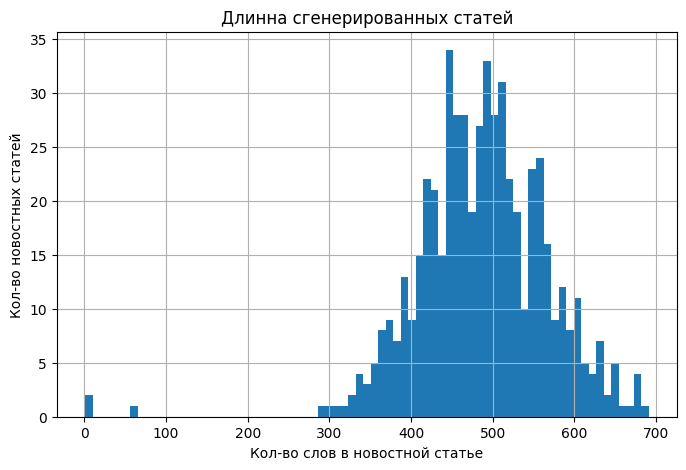

In [96]:
cnt_len_memmory = []
for paper in deepseek_write_papers.values():
    cnt_len_memmory.append(
        len(paper.split(' '))
    )

cnt_len_memmory = pd.Series(cnt_len_memmory)

# График
plt.figure(figsize=(8,5))
cnt_len_memmory.hist(bins=75)

plt.title('Длинна сгенерированных статей')
plt.xlabel('Кол-во слов в новостной статье')
plt.ylabel('Кол-во новостных статей')
plt.show()

In [97]:
dsv3_mean, dsv3_median, dsv3_q05, dsv3q95 = cnt_len_memmory.mean(), cnt_len_memmory.median(), cnt_len_memmory.quantile(0.05), cnt_len_memmory.quantile(0.95)
print('Generated paper')
print(f'Среднее: {dsv3_mean:.2f}, медиана: {dsv3_median:.2f}, квантиль 0,05: {dsv3_q05:.2f}, квантиль 0,95: {dsv3q95:.2f}')

Generated paper
Среднее: 487.00, медиана: 488.50, квантиль 0,05: 366.00, квантиль 0,95: 610.45


# 4. Обработка сгенерированных статей

## 4.1 Очистка от названия статьи в начале текста

In [101]:
# Пример до обработки
for key in gen_news_title_gpt4o[10:15]:
    paper = deepseek_write_papers[key]
    clean_paper = re.sub(r'^\*\*.*?\*\*\s*', '', paper)
    print(f'Title:       {key}, \nPaper:       {paper}\nClean paper: {clean_paper}\n')

Title:       Germany’s Refugee Policy Reversal: What Changed?, 
Paper:       **Germany’s Refugee Policy Reversal: What Changed?**  For years, Germany stood as a beacon of openness in Europe, welcoming hundreds of thousands of refugees fleeing war and persecution. Chancellor Angela Merkel’s famous declaration in 2015—“Wir schaffen das” (“We can do this”)—became symbolic of the country’s commitment to humanitarian responsibility. But nearly a decade later, the political winds have shifted dramatically. The recent tightening of asylum laws and border controls marks a stark reversal from Germany’s once-lauded refugee policy. What led to this change, and what does it mean for the future of migration in Europe?  ### The Golden Era of Open Borders  In 2015, Germany opened its doors to over a million refugees, primarily from Syria, Iraq, and Afghanistan. The move was met with both praise and backlash—humanitarian groups celebrated Germany’s moral leadership, while right-wing factions warned of

In [103]:
# Обработка
for key, paper in deepseek_write_papers.items():
    clean_paper = re.sub(r'^\*\*.*?\*\*\s*', '', paper) 
    deepseek_write_papers[key] = clean_paper

In [105]:
# Пример после
for key in gen_news_title_gpt4o[10:15]:
    paper = deepseek_write_papers[key]
    print(f'Title:       {key}, \nPaper:       {paper}\n')

Title:       Germany’s Refugee Policy Reversal: What Changed?, 
Paper:       For years, Germany stood as a beacon of openness in Europe, welcoming hundreds of thousands of refugees fleeing war and persecution. Chancellor Angela Merkel’s famous declaration in 2015—“Wir schaffen das” (“We can do this”)—became symbolic of the country’s commitment to humanitarian responsibility. But nearly a decade later, the political winds have shifted dramatically. The recent tightening of asylum laws and border controls marks a stark reversal from Germany’s once-lauded refugee policy. What led to this change, and what does it mean for the future of migration in Europe?  ### The Golden Era of Open Borders  In 2015, Germany opened its doors to over a million refugees, primarily from Syria, Iraq, and Afghanistan. The move was met with both praise and backlash—humanitarian groups celebrated Germany’s moral leadership, while right-wing factions warned of cultural erosion and economic strain. Despite the cha

## 4.2 Удаление коротких статей

In [110]:
del_key = []

for key, paper in deepseek_write_papers.items():
    if len(paper.split(' ')) < 250:
        del_key.append(key)

print(f'Будет удалено {len(del_key)} статьи')

for key in del_key:
    del deepseek_write_papers[key]

print(f'Итоговая количество статей {len(deepseek_write_papers)}')

Будет удалено 3 статьи
Итоговая количество статей 549


In [111]:
save_s3(pickle_data=deepseek_write_papers, object_key='deepseek_write_papers.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_write_papers.pkl', 'wb') as file: 
    pickle.dump(deepseek_write_papers, file)

# 5. Увеличение длинны статьи 

In [115]:
# Пример
system_content_create_long_news = (
    "You are an AI assistant and a skilled news journalist."
    "Your task is to analyze the short article below and expand it into a longer, more detailed and immersive article, while maintaining the original topic and logical structure."
    "* Use vivid and descriptive language, like a Guardian newspaper reporter."
    "* The final article should be between 600 and 1200 words."
    "* Add details, background, quotes, or context where needed."
    "* Keep the tone consistent with professional journalism."
    "Only output the expanded article — no explanations, no titles, no formatting instructions."
    "The original article to expand in content!"
    )


for key in gen_news_title_gpt4o[10:16]:
    try:
        paper = deepseek_write_papers[key]
        
        long_paper = dsv3_api_request(client=client_dsv3, query=paper, system_content=system_content_create_long_news)
        long_paper = long_paper.choices[0].message.content
        long_paper = long_paper.replace('\n', '')
        
        print(f'Title:     {key}, \nPaper:     {paper}\n Long paper: {long_paper}')
    except:
        pass

Title:     Germany’s Refugee Policy Reversal: What Changed?, 
Paper:     For years, Germany stood as a beacon of openness in Europe, welcoming hundreds of thousands of refugees fleeing war and persecution. Chancellor Angela Merkel’s famous declaration in 2015—“Wir schaffen das” (“We can do this”)—became symbolic of the country’s commitment to humanitarian responsibility. But nearly a decade later, the political winds have shifted dramatically. The recent tightening of asylum laws and border controls marks a stark reversal from Germany’s once-lauded refugee policy. What led to this change, and what does it mean for the future of migration in Europe?  ### The Golden Era of Open Borders  In 2015, Germany opened its doors to over a million refugees, primarily from Syria, Iraq, and Afghanistan. The move was met with both praise and backlash—humanitarian groups celebrated Germany’s moral leadership, while right-wing factions warned of cultural erosion and economic strain. Despite the challen

In [126]:
deepseek_write_long_papers = try_load(file_path=PATH+'data/', file_name='deepseek_write_long_papers.pkl', client_s3=client_s3)
befor_len = []
after_len = []

for i, key in enumerate(deepseek_write_papers.keys()):
    if key not in deepseek_write_long_papers.keys():

        print(f'---START {i}---')

        paper = deepseek_write_papers[key]
        
        long_paper = dsv3_api_request(client=client_dsv3, query=paper, system_content=system_content_create_long_news)
        long_paper = long_paper.choices[0].message.content
        long_paper = long_paper.replace('\n', '')

        clear_output(wait=True)
        
        print(f'---START {i}---')

        deepseek_write_long_papers[key] = long_paper

        bef = len(paper.split())
        aft = len(long_paper.split())

        befor_len.append(bef)
        after_len.append(aft)
        
        print(f'Title:     {key}, \nPaper:     {paper} \nLong paper: {long_paper}')
        print(f'Cnt word before {bef} after {aft}')

---START 548---
Title:     U.S. State Secession Resolutions: Symbolism or Start?, 
Paper:     In recent months, a quiet but growing movement has begun to ripple through several U.S. states, raising eyebrows and stirring debates about the future of the American union. Legislators in Texas, Florida, and even traditionally blue states like California have introduced resolutions—some symbolic, others more concrete—exploring the possibility of state secession. While the idea of states breaking away from the federal government is not new, the intensity and frequency of these discussions have reached levels not seen since the Civil War era.  The most vocal of these movements has been in Texas, where lawmakers have repeatedly floated the idea of a "Texit"—a play on Brexit—arguing that the state’s economic strength and cultural identity justify independence. Governor Greg Abbott has even gone so far as to suggest that Texas could "go it alone" if federal policies continue to clash with state pr

___Статистическое сравнение до и после обработки___

In [128]:
befor_len_ser = pd.Series(befor_len)

bef_mean, bef_median, bef_q05, bef_q95 = befor_len_ser.mean(), befor_len_ser.median(), befor_len_ser.quantile(0.05), befor_len_ser.quantile(0.95)
print('Generated paper')
print(f'Среднее: {bef_mean:.2f}, медиана: {bef_median:.2f}, квантиль 0,05: {bef_q05:.2f}, квантиль 0,95: {bef_q95:.2f}')

Generated paper
Среднее: 479.58, медиана: 478.00, квантиль 0,05: 363.40, квантиль 0,95: 594.20


In [129]:
after_len_ser = pd.Series(after_len)

aft_mean, aft_median, aft_q05, aft_q95 = after_len_ser.mean(), after_len_ser.median(), after_len_ser.quantile(0.05), after_len_ser.quantile(0.95)
print('Generated paper')
print(f'Среднее: {aft_mean:.2f}, медиана: {aft_median:.2f}, квантиль 0,05: {aft_q05:.2f}, квантиль 0,95: {aft_q95:.2f}')

Generated paper
Среднее: 843.86, медиана: 845.00, квантиль 0,05: 719.40, квантиль 0,95: 970.00


In [130]:
# Обработка регуляркой
for key, paper in deepseek_write_long_papers.items():
    clean_paper = re.sub(r'^\*\*.*?\*\*\s*', '', paper) 
    deepseek_write_long_papers[key] = clean_paper

In [131]:
# Сохранение
save_s3(pickle_data=deepseek_write_long_papers, object_key='deepseek_write_long_papers.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_write_long_papers.pkl', 'wb') as file: 
    pickle.dump(deepseek_write_long_papers, file)

# 6. Уход от паттернов генерации LLM

"очеловечивание статьи"

In [ ]:
from models.deepseekv3 import dsv3_evaluate_dsv3_paper_v3, dsv3_rewrite_dsv3_paper_v3

In [ ]:
# длинные статьи
deepseek_write_long_papers_keys = list(deepseek_write_long_papers.keys())

prepaid_keys = set()

for i, key in enumerate(deepseek_write_long_papers_keys):

        if key not in prepaid_keys:

                print(f'---START {i}---')

                # 1. Подготовленная статья к обработке
                paper_for_update = deepseek_write_long_papers[key]
                print('1. [ID 0] Подготовленная статья к обработке:', paper_for_update, '\n')

                # 2. Оценка статьи - подготовка предложений для избавления признаков LLM генерации
                eval_paper = dsv3_evaluate_dsv3_paper_v3(client=client_dsv3, generated_article=paper_for_update)
                eval_paper = eval_paper.choices[0].message.content.replace('\n', '')
                print('2. [ID 1] Замечания к статье', eval_paper, '\n')

                # 3. Редактирование статьи на основе оценки из п.2
                final_paper = dsv3_rewrite_dsv3_paper_v3(client=client_dsv3, news_article=paper_for_update, suggestions=eval_paper)
                final_paper = final_paper.choices[0].message.content.replace('\n\n', '\n')
                print('3. [ID 2] Статья после изменения:', final_paper, '\n')

                deepseek_write_long_papers[key] = [paper_for_update, eval_paper, final_paper]
                
                prepaid_keys.add(key)

                clear_output(wait=True)

                print(f'---START {i}---')
                
                print('1. [ID 0] Оригинальная статья:', paper_for_update, '\n')
                print('2. [ID 1] Замечания к статье', eval_paper, '\n')
                print('3. [ID 2] Статья после изменения:', final_paper, '\n')
                
                print('\n------------------------------------------------------------------------------------------------------------------')

                if len(deepseek_write_long_papers) % 10 == 0:
                    save_s3(pickle_data=deepseek_write_long_papers, object_key='deepseek_write_long_papers.pkl', client_s3=client_s3)

                    with open(PATH+'/data/deepseek_write_long_papers.pkl', 'wb') as file: 
                        pickle.dump(deepseek_write_long_papers, file)

save_s3(pickle_data=deepseek_write_long_papers, object_key='deepseek_write_long_papers.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_write_long_papers.pkl', 'wb') as file: 
    pickle.dump(deepseek_write_long_papers, file)

---START 548---
1. [ID 0] Оригинальная статья: In recent months, what began as a fringe political murmur has swelled into a tangible undercurrent of discontent, as lawmakers in states as politically divergent as Texas, Florida, and California have reignited a once-unthinkable debate: the possibility of seceding from the United States. While the notion of states breaking away from the federal government has flickered at the edges of American discourse for decades, the current wave of resolutions—some symbolic, others more substantive—has reached an intensity not seen since the Civil War. This resurgence of secessionist rhetoric is more than just political posturing; it is a symptom of a nation increasingly fractured along ideological, cultural, and economic lines. The Frontlines of the Movement Texas, long a hotbed of independence sentiment, has emerged as the most vocal proponent of what some have dubbed "Texit"—a nod to the United Kingdom’s Brexit from the European Union. The state’s 

In [ ]:
# Короткие статьи
deepseek_write_papers_keys = list(deepseek_write_papers.keys())

prepaid_keys = set()

for i, key in enumerate(deepseek_write_papers_keys):

        if key not in prepaid_keys:

                print(f'---START {i}---')

                # 1. Подготовленная статья к обработке
                paper_for_update = deepseek_write_papers[key]
                print('1. [ID 0] Подготовленная статья к обработке:', paper_for_update, '\n')

                # 2. Оценка статьи - подготовка предложений для избавления признаков LLM генерации
                eval_paper = dsv3_evaluate_dsv3_paper_v3(client=client_dsv3, generated_article=paper_for_update)
                eval_paper = eval_paper.choices[0].message.content.replace('\n', '')
                print('2. [ID 1] Замечания к статье', eval_paper, '\n')

                # 3. Редактирование статьи на основе оценки из п.2
                final_paper = dsv3_rewrite_dsv3_paper_v3(client=client_dsv3, news_article=paper_for_update, suggestions=eval_paper)
                final_paper = final_paper.choices[0].message.content.replace('\n\n', '\n')
                print('3. [ID 2] Статья после изменения:', final_paper, '\n')

                deepseek_write_papers[key] = [paper_for_update, eval_paper, final_paper]
                
                prepaid_keys.add(key)

                clear_output(wait=True)

                print(f'---START {i}---')
                
                print('1. [ID 0] Оригинальная статья:', paper_for_update, '\n')
                print('2. [ID 1] Замечания к статье', eval_paper, '\n')
                print('3. [ID 2] Статья после изменения:', final_paper, '\n')
                
                print('\n------------------------------------------------------------------------------------------------------------------')

                if len(deepseek_write_papers) % 10 == 0:
                    save_s3(pickle_data=deepseek_write_papers, object_key='deepseek_write_papers.pkl', client_s3=client_s3)

                    with open(PATH+'/data/deepseek_write_papers.pkl', 'wb') as file: 
                        pickle.dump(deepseek_write_papers, file)

save_s3(pickle_data=deepseek_write_papers, object_key='deepseek_write_papers.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_write_papers.pkl', 'wb') as file: 
    pickle.dump(deepseek_write_papers, file)